In [1]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T

from wildlife_tools.features import SuperPointExtractor
from wildlife_tools.similarity import MatchLOFTR, MatchLightGlue
from wildlife_tools.similarity.pairwise.collectors import CollectCounts, CollectCountsRansac, CollectAll
from wildlife_tools.data import ImageDataset

metadata = {'metadata':  pd.read_csv('../tests/TestDataset/metadata.csv'), 'root': '../tests/TestDataset'}
dataset = ImageDataset(**metadata)
dataset_img = ImageDataset(**metadata, transform=T.Resize([256, 256]))

# LightGlue

In [2]:
extractor = SuperPointExtractor()
dataset.transform = T.Compose([T.Resize([224, 224]), T.ToTensor()])

features_query = extractor(dataset)
features_database = extractor(dataset)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59it/s]


### Default SuperPoint + LightGlue matching score
- Default score is number of significant (confidence > 0.5) correspondences.

In [4]:
matcher = MatchLightGlue(features='superpoint')
output = matcher(features_query, features_database)
output

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


array([[246.,  51.,   0.,   2.],
       [ 51., 220.,   3.,   0.],
       [  0.,   3., 222.,  15.],
       [  2.,   0.,  15., 197.]], dtype=float16)

### Collect scores from multiple thresholds
- Suitable for calculation of scores from multiple thresholds at once.

In [5]:
collector = CollectCounts(thresholds=[0.2, 0.5, 0.8])
matcher = MatchLightGlue(features='superpoint', collector=collector)
output = matcher(features_query, features_database)
output

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


{0.2: array([[256.,  96.,   6.,   7.],
        [ 96., 244.,   6.,   0.],
        [  6.,   6., 248.,  31.],
        [  7.,   0.,  31., 240.]], dtype=float16),
 0.5: array([[246.,  51.,   0.,   2.],
        [ 51., 220.,   3.,   0.],
        [  0.,   3., 222.,  15.],
        [  2.,   0.,  15., 197.]], dtype=float16),
 0.8: array([[198.,  14.,   0.,   1.],
        [ 14., 177.,   0.,   0.],
        [  0.,   0., 148.,   3.],
        [  1.,   0.,   3., 136.]], dtype=float16)}

### Collect after RANSAC filtering

In [6]:
collector = CollectCountsRansac(ransacReprojThreshold=1.0, maxIters=100)
matcher = MatchLightGlue(features='superpoint', collector=collector)
output = matcher(features_query, features_database)
output

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


array([[256.,  76.,  11.,   9.],
       [ 82., 252.,  10.,   0.],
       [ 11.,  10., 256.,  31.],
       [  9.,   0.,  31., 252.]], dtype=float16)

## Collect all
- Collect all SuperPoint keypoint and descriptors as list of dict

In [7]:
collector = CollectAll()
matcher = MatchLightGlue(features='superpoint', collector=collector)
output = matcher(features_query, features_database)
print(len(output)) # = len(query) x len(database) 
output

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


16


[{'idx0': 0,
  'idx1': 0,
  'kpts0': array([[ 78.5, 142.5],
         [206.5,  90.5],
         [ 99.5, 181.5],
         [ 57.5,  19.5],
         [ 77.5, 191.5],
         [ 70.5, 181.5],
         [156.5, 179.5],
         [116.5, 174.5],
         [ 85.5, 109.5],
         [109.5, 141.5],
         [131.5, 114.5],
         [157.5, 190.5],
         [194.5,  81.5],
         [ 98.5, 149.5],
         [140.5, 173.5],
         [184.5, 139.5],
         [ 90.5, 194.5],
         [153.5,  62.5],
         [ 70.5, 207.5],
         [171.5,  72.5],
         [197.5, 117.5],
         [ 84.5,  49.5],
         [ 63.5, 166.5],
         [123.5, 150.5],
         [112.5, 120.5],
         [ 39.5,  58.5],
         [ 59.5, 155.5],
         [213.5, 152.5],
         [ 78.5,  85.5],
         [ 56.5, 185.5],
         [186.5, 167.5],
         [ 62.5, 197.5],
         [151.5, 124.5],
         [161.5, 147.5],
         [166.5, 132.5],
         [ 31.5,  21.5],
         [118.5, 163.5],
         [ 96.5,  73.5],
         [126.5

# LoFTR
- Default score is number of significant (confidence > 0.5) correspondences.

In [8]:
dataset.transform = T.Compose([T.Resize([256, 256]), T.Grayscale(), T.ToTensor()])

matcher = MatchLOFTR()
output = matcher(dataset, dataset)
output

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.41s/it]


array([[784., 369.,  13.,   9.],
       [359., 784.,   9.,  10.],
       [  9.,  12., 784.,  13.],
       [  9.,   8.,   8., 784.]], dtype=float16)

# Visualise matches

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from wildlife_tools.similarity.pairwise.utils import visualise_matches

### Match first and second images from the dataset
- Images are similar, and there are a lot of matches even with high init_threshold.

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


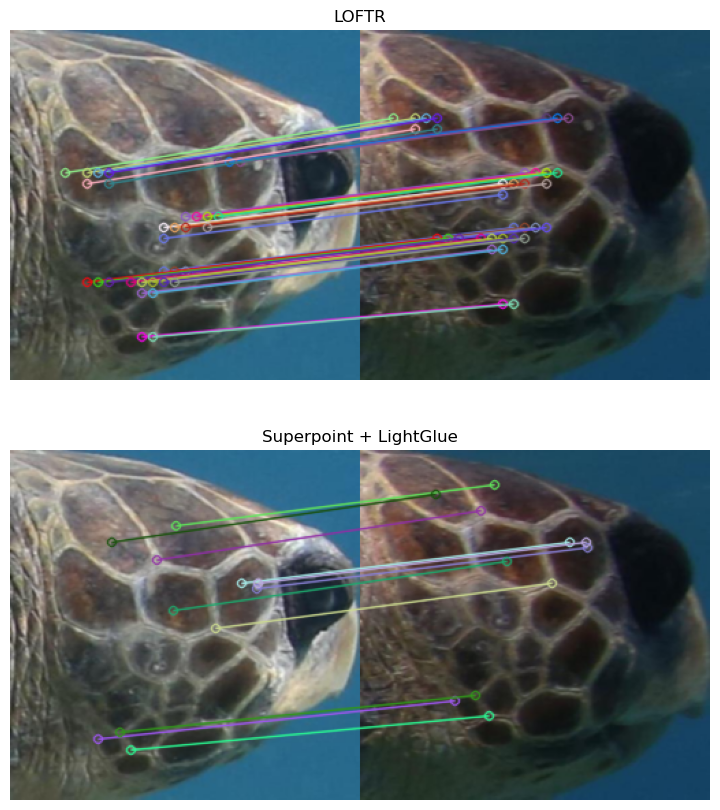

In [11]:
idx0 = 0
idx1 = 1

img0, _ = dataset_img[idx0]
img1, _ = dataset_img[idx1]

# Match the images - LOFTR
dataset.transform = T.Compose([T.Resize([256, 256]), T.Grayscale(), T.ToTensor()])
matcher = MatchLOFTR(collector = CollectAll(), init_threshold=0.99)
results_loftr = matcher(dataset, dataset, pairs=[(idx0, idx1)])[0]


# Match the images - Light GLue
dataset.transform = T.Compose([T.Resize([256, 256]), T.ToTensor()])
dataset_feat = SuperPointExtractor()(dataset)
matcher = MatchLightGlue(features='superpoint', collector = CollectAll(), init_threshold=0.8)
results_sp = matcher(dataset_feat, dataset_feat, pairs=[(idx0, idx1)])[0]


# Visualise
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title('LOFTR')
ax[1].set_title('Superpoint + LightGlue')
visualise_matches(img0, results_loftr['kpts0'], img1, results_loftr['kpts1'],ax = ax[0])
visualise_matches(img0, results_sp['kpts0'], img1, results_sp['kpts1'],ax = ax[1])

# Match second and third images
- Significant rotation of the head. Number of significant matches drops and there can be some spurious matches.

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


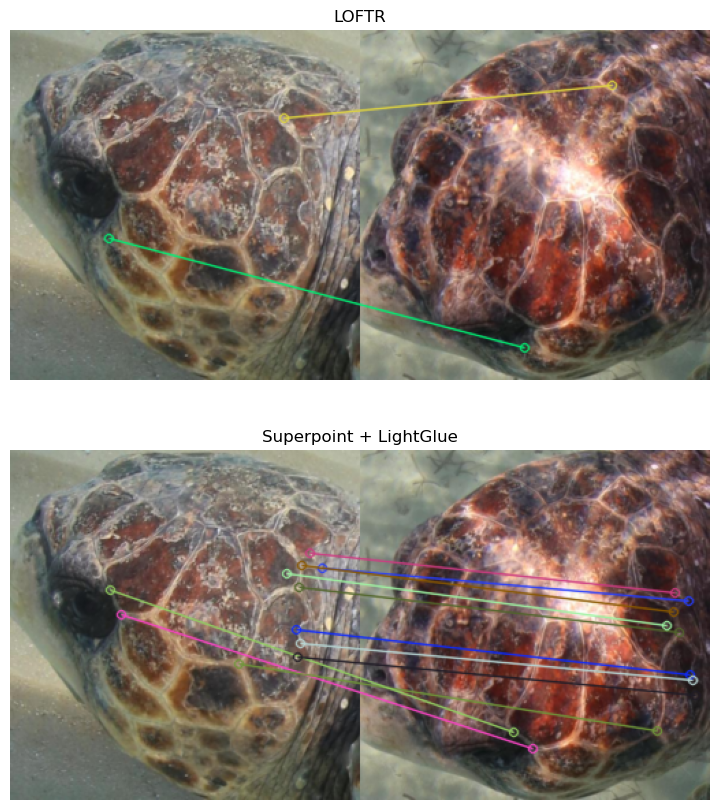

In [12]:
idx0 = 2
idx1 = 3

img0, _ = dataset_img[idx0]
img1, _ = dataset_img[idx1]

# Match the images - LOFTR
dataset.transform = T.Compose([T.Resize([256, 256]), T.Grayscale(), T.ToTensor()])
matcher = MatchLOFTR(collector = CollectAll(), init_threshold=0.68)
results_loftr = matcher(dataset, dataset, pairs=[(idx0, idx1)])[0]


# Match the images - Light GLue
dataset.transform = T.Compose([T.Resize([256, 256]), T.ToTensor()])
dataset_feat = SuperPointExtractor()(dataset)
matcher = MatchLightGlue(features='superpoint', collector = CollectAll(), init_threshold=0.65)
results_sp = matcher(dataset_feat, dataset_feat, pairs=[(idx0, idx1)])[0]


# Visualise
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title('LOFTR')
ax[1].set_title('Superpoint + LightGlue')
visualise_matches(img0, results_loftr['kpts0'], img1, results_loftr['kpts1'],ax = ax[0])
visualise_matches(img0, results_sp['kpts0'], img1, results_sp['kpts1'],ax = ax[1])